# Spike‑Timing‑Dependent Plasticity (STDP) – Practice Lab
Welcome to the hands‑on lab for exploring STDP!  
In this notebook you will:
1. Implement the Song–Abbott–Miller leaky integrate‑and‑fire (LIF) neuron model with pair‑based STDP.  
2. Generate several kinds of presynaptic spike trains.  
3. Run three guided experiments and interpret the results.

## Learning goals
After completing the notebook you should be able to:
* Explain how the relative timing of pre‑ and postsynaptic spikes drives synaptic potentiation or depression.
* Describe how STDP can stabilize a neuron’s output rate across a wide range of input rates.
* Show that STDP favors inputs with shorter latencies.
* Demonstrate that STDP selects inputs whose spikes are correlated on the time‑scale of the STDP window.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# For reproducibility
rng = np.random.default_rng(seed=42)

Cycle  0: weights [0.416  0.3718 0.3147 0.2409 0.1455]  post spike @ 0.024 ms
Cycle  1: weights [0.4903 0.3813 0.1398 0.0373 0.0343]  post spike @ 0.011 ms
Cycle  2: weights [0.4848 0.3502 0.0396 0.0373 0.0343]  post spike @ 0.010 ms
Cycle  3: weights [0.4848 0.3191 0.0396 0.0373 0.0343]  post spike @ 0.010 ms
Cycle  4: weights [0.4848 0.2881 0.0396 0.0373 0.0343]  post spike @ 0.010 ms
Cycle  5: weights [0.4848 0.257  0.0396 0.0373 0.0343]  post spike @ 0.010 ms
Cycle  6: weights [0.4848 0.2259 0.0396 0.0373 0.0343]  post spike @ 0.010 ms
Cycle  7: weights [0.4848 0.1949 0.0396 0.0373 0.0343]  post spike @ 0.010 ms
Cycle  8: weights [0.4848 0.1638 0.0396 0.0373 0.0343]  post spike @ 0.010 ms
Cycle  9: weights [0.4908 0.1682 0.0396 0.0373 0.0343]  post spike @ 0.010 ms


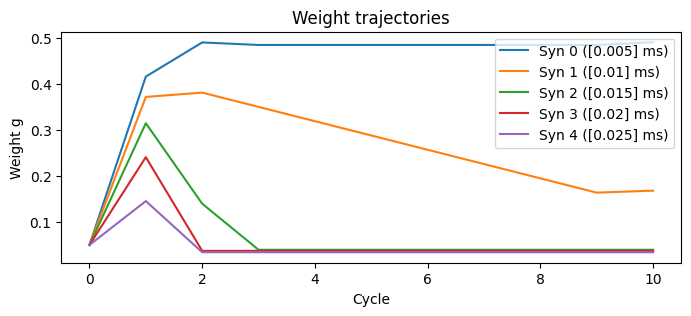

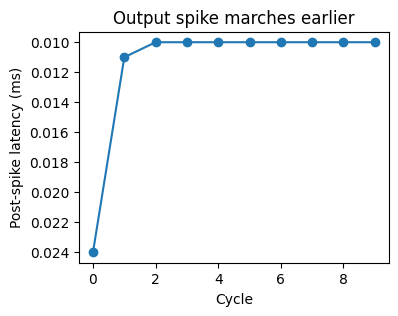

In [80]:
# ---------- Global simulation parameters ----------
dt       = 1e-3       # simulation time step [s]
tau_m    = 20e-3      # membrane time constant [s]
v_rest   = -0.070     # resting potential [V]
v_reset  = -0.060     # reset potential [V]
v_th     = -0.054     # spike threshold [V]
tau_ex   = 5e-3       # excitatory synaptic decay [s]
tau_in   = 5e-3       # inhibitory synaptic decay [s]

g_max    = 0.5     # max excitatory weight (dimensionless w.r.t. leak conductance)
g_in     = 0.05       # fixed inhibitory weight per spike

def run_simple(exc_spike_trains, g, T):
    """Simulate the LIF neuron for T seconds.
    exc_spike_trains – list of numpy arrays with spike times for each excitatory synapse.
    inh_spike_trains – list of numpy arrays with spike times for each excitatory synapse..
    Returns (postsynaptic spike times, final weights list)."""
    n_exc = len(exc_spike_trains)


    n_steps = int(T / dt)
    v = v_rest
    g_ex = g_inh = 0.0
    M = 0.0
    P = np.zeros(n_exc)
    post_spk = []

    for step in range(n_steps):
        t = step * dt

        # Inject scheduled excitatory spikes at this time step
        for a, spks in enumerate(exc_spike_trains):
            # all spikes for a synapse a that happened in the last time step.
            if spks[0] <= t and spks.size:
                g_ex += g[a]
                P[a] += A_plus # update LTP trace
                g[a] = max(g[a] + M * g_max, 0.0) # apply LTD trace
                np.delete(exc_spike_trains[a],0)

        # Decay conductances
        g_ex -= (dt / tau_ex) * g_ex
        g_inh -= (dt / tau_in) * g_inh

        # Decay pre/post traces
        M -= M / tau_minus * dt
        P -= P / tau_plus * dt
        
        # Update membrane potential
        dv = (v_rest - v - g_ex * v + g_inh * (v_rest - v)) / tau_m * dt # E_inh = V_rest
        v += dv

        # Check for spike
        if v >= v_th:
            post_spk.append(t)
            v = v_reset
            M -= A_minus # update LTD trace
            g += P * g_max
            np.minimum(g, g_max, out=g) # apply LTP trace

    return np.array(post_spk), g


# -- experiment parameters --
latency_spikes = np.array([[0.005],
                           [0.010], 
                           [0.015], 
                           [0.020], 
                           [0.025]])               
T            = 0.050                               # 50 ms cycle
cycles       = 10

# -- run the experiment --
g = np.full(latencies.size, 0.1 * g_max)# small initial weights
g_history = [g.copy()]
post_spike_history = []

for c in range(cycles):
    post_spike, g = run_simple(latency_spikes, g, T)
    g_history.append(g.copy())
    if post_spike.size:
        post_spike_history.append(post_spike[0])
    else:
        post_spike_history.append(np.nan)
    print(f'Cycle {c:2d}: weights {np.round(g,4)}  post spike @ {post_spike_history[-1]:.3f} ms')

# -- plot evolution --
g_history = np.array(g_history)

plt.figure(figsize=(8,3))
for i in range(len(latencies_ms)):
    plt.plot(g_history[:, i], label=f'Syn {i} ({latencies_ms[i]} ms)')
plt.xlabel('Cycle'); plt.ylabel('Weight g'); plt.legend()
plt.title('Weight trajectories'); plt.show()

plt.figure(figsize=(4,3))
plt.plot(post_spike_history, marker='o')
plt.gca().invert_yaxis()  # earlier = up
plt.xlabel('Cycle'); plt.ylabel('Post-spike latency (ms)')
plt.title('Output spike marches earlier'); plt.show()

In [57]:
np.delete(latency_spikes[1], 0)

array([], dtype=float64)

## 1 · Neuron and synapse model
We follow the parameters reported by **Song et al. 2000** for their current‑based LIF neuron 【τ_m = 20 ms, V_rest = −70 mV, V_th = −54 mV, V_reset = −60 mV, τ_ex = τ_in = 5 ms, g_max = 0.015 (dimensionless)】.  Weights are bounded in **[0, g_max]** and updated with the classical pair‑based STDP rule:
$$\Delta g = \begin{cases}
A_+\,e^{\Delta t/\tau_+} & \Delta t<0\\[2pt]
-A_-\,e^{-\Delta t/\tau_-} & \Delta t\ge0\end{cases}$$
with $\tau_+=\tau_-\;{=}$ 20 ms, $A_+=0.005\,g_{\max}$ and $A_-/A_+=1.05$.

In [38]:
# ---------- Global simulation parameters ----------
dt       = 1e-3       # simulation time step [s]
tau_m    = 20e-3      # membrane time constant [s]
v_rest   = -0.070     # resting potential [V]
v_reset  = -0.060     # reset potential [V]
v_th     = -0.054     # spike threshold [V]
tau_ex   = 5e-3       # excitatory synaptic decay [s]
tau_in   = 5e-3       # inhibitory synaptic decay [s]

g_max    = 0.15      # max excitatory weight (dimensionless w.r.t. leak conductance)
g_in     = 0.05       # fixed inhibitory weight per spike

# STDP constants
tau_plus  = 20e-3
tau_minus = 20e-3
A_plus    = 0.005     # fraction of g_max added per causal pair
A_minus   = 1.05*A_plus

# Network size
N_exc  = 250          # number of excitatory synapses (reduced for speed)
N_inh  = 50          # number of inhibitory synapses


### Spike‑train generators

In [81]:
def poisson_spike_times(rate, T, rng=rng):
    """Return sorted spike times for a homogeneous Poisson process (Hz) up to T seconds."""
    n_exp = rng.poisson(rate * T * 1.5)  # safety factor
    isi = rng.exponential(1.0 / rate, size=n_exp)
    t = np.cumsum(isi)
    return t[t < T]

### Minimal LIF + STDP simulator
The function below simulates a single postsynaptic neuron receiving *N_exc* excitatory and *N_inh* inhibitory synapses.  
Excitatory weights are plastic; inhibitory ones are fixed.

In [43]:
def run_sim(exc_spike_trains, inh_spike_trains, T):
    """Simulate the LIF neuron for T seconds.
    exc_spike_trains – list of numpy arrays with spike times for each excitatory synapse.
    inh_spike_trains – list of numpy arrays with spike times for each excitatory synapse..
    Returns (postsynaptic spike times, final weights list)."""
    n_exc = len(exc_spike_trains)
    g = np.full(n_exc, 1.0 * g_max)

    n_steps = int(T / dt)
    v = v_rest
    g_ex = g_inh = 0.0
    M = 0.0
    P = np.zeros(n_exc)
    post_spk = []

    for step in range(n_steps):
        t = step * dt

        # Inject scheduled excitatory spikes at this time step
        for a, spks in enumerate(exc_spike_trains):
            # all spikes for a synapse a that happened in the last time step.
            while spks.size and spks[0] <= t:
                g_ex += g[a]
                P[a] += A_plus # update LTP trace
                g[a] = max(g[a] + M * g_max, 0.0) # apply LTD trace
                spks = spks[1:]
                exc_spike_trains[a] = spks
        
        for a, i_spks in enumerate(inh_spike_trains):
            # all spikes for a synapse a that happened in the last time step.
            while i_spks.size and i_spks[0] <= t:
                g_inh += g_in
                i_spks = i_spks[1:]
                inh_spike_trains[a] = i_spks

        # Decay conductances
        g_ex -= (dt / tau_ex) * g_ex
        g_inh -= (dt / tau_in) * g_inh

        # Decay pre/post traces
        M -= M / tau_minus * dt
        P -= P / tau_plus * dt
        
        # Update membrane potential
        dv = (v_rest - v - g_ex * v + g_inh * (v_rest - v)) / tau_m * dt # E_inh = V_rest
        v += dv

        # Check for spike
        if v >= v_th:
            post_spk.append(t)
            v = v_reset
            M -= A_minus # update LTD trace
            g += P * g_max
            np.minimum(g, g_max, out=g) # apply LTP trace

    return np.array(post_spk), g

## 2 · Task 1 – Firing‑rate homeostasis with Poisson input
Run the neuron with **independent Poisson input** at three mean presynaptic rates.  Confirm that, despite strong changes in input rate, the **postsynaptic firing rate** changes only modestly and the distribution of excitatory weights becomes bimodal.

Input rate 10 Hz → output rate: 79.67 Hz
Input rate 20 Hz → output rate: 57.65 Hz
Input rate 40 Hz → output rate: 60.74 Hz


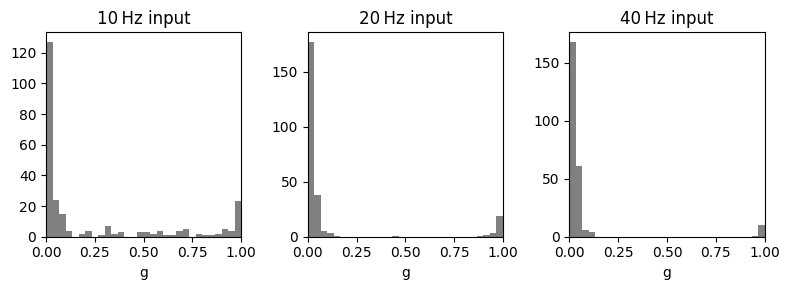

In [44]:
# --- CONFIGURATION ---
T_sim   = 200.0     # seconds per experiment (increase for better convergence)
rates   = [10, 20, 40]  # Hz
inh_rate = 10      # Hz per inhibitory synapse

all_results = {}
for rate in rates:
    exc_trains = [poisson_spike_times(rate, T_sim) for _ in range(N_exc)]
    inh_trains = [poisson_spike_times(inh_rate, T_sim) for _ in range(N_inh)]
    post_spk, w_final = run_sim([np.copy(tr) for tr in exc_trains], [np.copy(tr) for tr in inh_trains], T_sim)
    all_results[rate] = (post_spk, w_final)
    print(f'Input rate {rate} Hz → output rate: {len(post_spk)/T_sim:.2f} Hz')

plt.figure(figsize=(8,3))
for i, rate in enumerate(rates):
    plt.subplot(1,3,i+1)
    plt.hist(np.divide(all_results[rate][1], g_max), bins=30, color='grey')
    plt.title(f'{rate} Hz input')
    plt.xlim(0, 1.0)
    plt.xlabel('g')
plt.tight_layout()
plt.show()

> **Discussion**  
*Does the postsynaptic rate plateau as predicted in the paper?*  Explore different values of `A_minus/A_plus` or `g_max` and observe the effect on stability.

## 3 · Task 2 – Latency coding
Here we build **one burst per synapse per cycle**, but each synapse has a different fixed latency drawn from a Gaussian distribution.  Run several cycles and show that STDP strengthens short‑latency inputs while depressing long‑latency ones.

> **Try this**  
Increase the latency spread or the burst period and rerun.  How does the slope of the weight‑vs‑latency cloud change?

> **Reflection**  
How does decreasing the correlation time constant (or using bursty synchrony) influence the separation between the two groups?  Relate your observations to the 20 ms STDP time window.